In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing as size
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size)

<module 'position_sizing' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [8]:
client = cn.get_coinbase_rest_api_client(cn.key_location)

In [10]:
def get_coinbase_daily_historical_price_data_hour(client, ticker, start_timestamp, end_timestamp, retries=3, delay=5, granularity='ONE_HOUR'):
    # granularity = 'ONE_DAY'  # Daily granularity
    attempts = 0

    while attempts < retries:
        try:
            # Attempt to fetch the candles
            candle_list = client.get_candles(
                product_id=ticker,
                start=start_timestamp,
                end=end_timestamp,
                granularity=granularity
            ).candles

            # Process candle data
            candle_data = []
            for candles in candle_list:
                candle_info = {
                    'date': candles['start'],
                    'low': float(candles['low']),
                    'high': float(candles['high']),
                    'open': float(candles['open']),
                    'close': float(candles['close']),
                    'volume': float(candles['volume'])
                }
                candle_data.append(candle_info)

            # Convert to DataFrame
            df_candles = pd.DataFrame(candle_data).sort_values('date')
            df_candles['date'] = pd.to_datetime(df_candles['date'], unit='s').dt.date
            df_candles = df_candles.set_index('date')
            # df_candles['ticker'] = ticker

            return df_candles, candle_list

        except requests.exceptions.ConnectionError as e:
            print(f"Connection error: {e}. Retrying in {delay} seconds...")
            attempts += 1
            time.sleep(delay)

    # If all retries fail, raise the error
    raise Exception("Max retries exceeded. Could not connect to Coinbase API.")

In [12]:
import requests
import time
import datetime
import pandas as pd

def get_coinbase_price_at_timestamp(client, ticker, start_date, end_date, timestamp='08:00:00', retries=3, delay=5):
    """
    Fetches the price of a cryptocurrency at a specified timestamp for using the Coinbase REST API.

    Parameters:
    - client: The Coinbase API client
    - ticker: The crypto trading pair (e.g., 'BTC-USD')
    - retries: Number of retry attempts in case of failure
    - delay: Delay between retries in seconds

    Returns:
    - A Pandas DataFrame with date and 8 AM price
    """

    date_list = pd.date_range(start=start_date, end=end_date, freq="D")
    price_data = []

    for date in date_list:
        start_timestamp = int(datetime.datetime.strptime(f'{date.date()} {timestamp}','%Y-%m-%d %H:%M:%S').timestamp())
        end_timestamp = int(datetime.datetime.strptime(f'{date.date()} {timestamp}','%Y-%m-%d %H:%M:%S').timestamp())

        attempts = 0
        while attempts < retries:
            try:
                # Fetch 8 AM hourly candle
                candle_list = client.get_candles(
                    product_id=ticker,
                    start=start_timestamp,
                    end=end_timestamp,
                    granularity='ONE_MINUTE'  # Minute candles
                ).candles

                if candle_list:
                    # Extract price at timestamp
                    candles = candle_list[0]  # [timestamp, low, high, open, close, volume]
                    price_data.append({
                        'date': datetime.datetime.utcfromtimestamp(int(candles['start'])).date(),
                        '8am_open_price': float(candles['open']),
                        '8am_close_price': float(candles['close'])
                    })

                break  # Exit retry loop if successful

            except requests.exceptions.ConnectionError as e:
                print(f"Connection error: {e}. Retrying in {delay} seconds...")
                attempts += 1
                time.sleep(delay)

        if attempts == retries:
            print(f"Failed to fetch data for {date.strftime('%Y-%m-%d')} after {retries} retries.")

    # Convert to DataFrame
    df_prices = pd.DataFrame(price_data)
    df_prices.set_index('date', inplace=True)

    return df_prices

In [16]:
def save_historical_crypto_prices_at_timestamp_from_coinbase(ticker_list, user_start_date=False, start_date=None, end_date=None, window_days=30, timestamp='08:00:00',
                                                             save_to_file=False):

    client = cn.get_coinbase_rest_api_client(cn.key_location)
    if user_start_date:
        start_date = pd.Timestamp(start_date).date()
    else:
        start_date = cn.coinbase_start_date_by_ticker_dict.get(ticker)
        start_date = pd.Timestamp(start_date).date()
        if not start_date:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None

    if pd.Timestamp(end_date).date() > datetime.datetime.now().date():
        end_date = datetime.datetime.now().date()
    
    price_dict = {}
    for ticker in ticker_list:
        current_start_date = start_date
        current_end_date = current_start_date + datetime.timedelta(days=window_days)
        cols = [f'{ticker}_8am_open_price', f'{ticker}_8am_close_price']
        df = pd.DataFrame(columns=cols)
        while current_start_date < pd.Timestamp(end_date).date():
            if (current_start_date < pd.Timestamp(end_date).date()) & (current_end_date > pd.Timestamp(end_date).date()):
                current_end_date = pd.Timestamp(end_date).date()
            print(ticker, current_start_date, current_end_date)
            _df = get_coinbase_price_at_timestamp(client, ticker, current_start_date,
                                                  current_end_date, timestamp)
            _df.columns = cols
            df = pd.concat([df, _df])
            current_start_date = current_end_date + datetime.timedelta(days=1)
            current_end_date = current_end_date + datetime.timedelta(days=window_days)
    
        if save_to_file:
            filename = f"{ticker}-{timestamp}_pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df.to_pickle(output_file)

        price_dict[ticker] = df
    
    df_price = pd.concat(price_dict, axis=1)
    df_price.columns = df_price.columns.droplevel(level=0)

    return df_price

In [ ]:
start_date = '2021-06-01'
end_date = '2025-03-31'
df_prices = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker_list, user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False)

In [457]:
df_prices.tail(200)

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,ETH-USD_8am_open_price,ETH-USD_8am_close_price,LTC-USD_8am_open_price,LTC-USD_8am_close_price,SOL-USD_8am_open_price,SOL-USD_8am_close_price
2024-08-12,59874.43,59797.06,2674.47,2671.77,61.70,61.67,150.33,150.18
2024-08-13,58845.51,58849.89,2645.12,2645.93,61.79,61.76,145.91,146.13
2024-08-14,61340.31,61327.00,2753.05,2752.12,63.67,63.64,148.09,148.06
2024-08-15,58744.40,58777.77,2637.68,2638.90,65.28,65.32,143.12,143.22
2024-08-16,58412.61,58421.66,2612.74,2614.65,65.72,65.69,142.02,142.13
2024-08-17,59135.31,59127.07,2599.63,2598.67,67.31,67.35,139.14,139.03
2024-08-18,60020.79,59991.77,2650.05,2648.70,67.62,67.61,144.62,144.54
2024-08-19,58404.81,58455.94,2588.23,2588.04,66.83,66.91,142.37,142.42
2024-08-20,60547.22,60541.69,2643.78,2643.55,66.16,66.17,145.43,145.42
2024-08-21,59374.84,59391.77,2577.91,2577.77,62.77,62.77,141.32,141.28


In [469]:
end_date

'2025-03-31'

In [477]:
start_date = '2021-06-01'
end_date = '2025-02-27'
ticker = 'BTC-USD'
filename = f"{ticker}-08:00:00_pickle-{pd.to_datetime(start_date).date().strftime('%Y-%m-%d')}-{pd.to_datetime(end_date).date().strftime('%Y-%m-%d')}"
df_test = pd.read_pickle(f'coinbase_historical_price_folder/{filename}')

In [481]:
df_test.head(200)

,BTC-USD_8am_open_price,BTC-USD_8am_close_price
2021-06-01,36601.20,36545.54
2021-06-02,37204.26,37242.00
2021-06-03,38791.36,38811.27
2021-06-04,36587.77,36403.02
2021-06-05,35915.26,35821.11
2021-06-06,35893.44,35858.47
2021-06-07,36395.00,36424.28
2021-06-08,33123.94,33153.76
2021-06-09,35017.72,35199.99
2021-06-10,37843.96,37787.97


In [18]:
def load_coinbase_timestamp_price_pickle_file(ticker):
    start_date = pd.Timestamp('2021-06-01').date()
    end_date = pd.Timestamp('2025-02-27').date()
    filename = f"{ticker}-8_am_pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
    df = pd.read_pickle(f'coinbase_historical_price_folder/{filename}')
    df[f'{ticker}_8am_t_1_close'] = df[f'{ticker}_8am_close_price'].shift(1)

    return df

In [20]:
def create_trend_strategy_timestamp(ticker_list, mavg_start=50, mavg_end=250, mavg_stepsize=6):
    ticker_dict = {}
    for ticker in ticker_list:
        df = load_coinbase_timestamp_price_pickle_file(ticker)
        open_price_col = f'{ticker}_8am_open_price'
        close_price_col = f'{ticker}_8am_close_price'
        t_1_close_price_col = f'{ticker}_8am_t_1_close'
        df[f'{ticker}_pct_returns'] = (df[open_price_col] - df[t_1_close_price_col]) / df[t_1_close_price_col]#df[price_col].pct_change()
    
        for window in np.linspace(mavg_start, mavg_end, mavg_stepsize):
            df[f'{ticker}_{int(window)}_mavg'] = df[f'{open_price_col}'].ewm(span=window).mean()
            
        ## Ticker Trend Signal and Trade
        mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(mavg_start, mavg_end, mavg_stepsize).tolist()]
        df[f'{ticker}_trend_signal'] = df[mavg_col_list].apply(tf.trend_signal, axis=1)#.shift(1)

        ticker_dict[ticker] = df

    df_final = pd.concat(ticker_dict, axis=1)
    df_final.columns = df_final.columns.droplevel(level=0)

    return df_final

In [22]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']

In [24]:
df_trend = create_trend_strategy_timestamp(ticker_list)

In [26]:
df_trend.head(20)

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_8am_t_1_close,BTC-USD_pct_returns,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg,BTC-USD_trend_signal,ETH-USD_8am_open_price,ETH-USD_8am_close_price,ETH-USD_8am_t_1_close,ETH-USD_pct_returns,ETH-USD_50_mavg,ETH-USD_90_mavg,ETH-USD_130_mavg,ETH-USD_170_mavg,ETH-USD_210_mavg,ETH-USD_250_mavg,ETH-USD_trend_signal,LTC-USD_8am_open_price,LTC-USD_8am_close_price,LTC-USD_8am_t_1_close,LTC-USD_pct_returns,LTC-USD_50_mavg,LTC-USD_90_mavg,LTC-USD_130_mavg,LTC-USD_170_mavg,LTC-USD_210_mavg,LTC-USD_250_mavg,LTC-USD_trend_signal,SOL-USD_8am_open_price,SOL-USD_8am_close_price,SOL-USD_8am_t_1_close,SOL-USD_pct_returns,SOL-USD_50_mavg,SOL-USD_90_mavg,SOL-USD_130_mavg,SOL-USD_170_mavg,SOL-USD_210_mavg,SOL-USD_250_mavg,SOL-USD_trend_signal
2021-06-01,36601.20,36545.54,NaN,NaN,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,-1,2624.78,2616.32,NaN,NaN,2624.780000,2624.780000,2624.780000,2624.780000,2624.780000,2624.780000,-1,181.80,181.47,NaN,NaN,181.800000,181.800000,181.800000,181.800000,181.800000,181.800000,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-02,37204.26,37242.00,36545.54,0.018025,36908.760600,36906.080333,36905.049462,36904.503706,36904.165857,36903.936120,1,2695.44,2699.21,2616.32,0.030241,2660.816600,2660.502556,2660.381769,2660.317824,2660.278238,2660.251320,1,182.47,182.76,181.47,0.005511,182.141700,182.138722,182.137577,182.136971,182.136595,182.136340,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-03,38791.36,38811.27,37242.00,0.041602,37561.559032,37548.523069,37543.517641,37540.869664,37539.231128,37538.117228,1,2808.70,2810.43,2699.21,0.040564,2712.095726,2711.003483,2710.583721,2710.361574,2710.224083,2710.130602,1,192.28,192.21,182.76,0.052090,185.657194,185.594544,185.570529,185.557835,185.549982,185.544646,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-04,36587.77,36403.02,38811.27,-0.057290,37303.314152,37300.269887,37299.038744,37298.373504,37297.957035,37297.671807,1,2625.76,2607.40,2810.43,-0.065709,2689.199844,2688.977047,2688.885933,2688.836483,2688.805452,2688.784168,1,173.85,172.76,192.21,-0.095521,182.525974,182.559820,182.572435,182.579022,182.583069,182.585807,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-05,35915.26,35821.11,36403.02,-0.013399,37003.059475,37010.821469,37013.702441,37015.203975,37016.125248,37016.748104,-1,2642.08,2633.10,2607.40,0.013301,2679.007191,2679.176196,2679.234512,2679.263870,2679.281516,2679.293285,-1,173.75,173.04,172.76,0.005730,180.627614,180.718686,180.753241,180.771427,180.782646,180.790258,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-06,35893.44,35858.47,35821.11,0.002019,36799.146465,36814.093578,36819.737790,36822.701599,36824.527790,36825.765837,-1,2692.28,2686.43,2633.10,0.022475,2681.446314,2681.483272,2681.493235,2681.497527,2681.499837,2681.501257,-1,176.54,176.16,173.04,0.020227,179.876439,179.982980,180.023752,180.045285,180.058596,180.067639,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-07,36395.00,36424.28,35858.47,0.014962,36734.257052,36750.158641,36756.224874,36759.423877,36761.399656,36762.741143,-1,2814.78,2816.95,2686.43,0.047777,2702.854257,2701.818391,2701.424193,2701.216441,2701.088158,2701.001067,1,180.79,180.83,176.16,0.026283,180.023120,180.106095,180.138332,180.155464,180.166091,180.173327,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-08,33123.94,33153.76,36424.28,-0.090608,36217.315136,36260.852148,36277.368073,36286.057534,36291.417477,36295.053725,-1,2534.92,2537.43,2816.95,-0.100119,2678.808653,2679.297833,2679.473364,2679.563440,2679.618209,2679.655019,-1,159.27,159.67,180.83,-0.119228,177.051592,177.294561,177.387187,177.436025,177.466188,177.486666,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-09,35017.72,35199.99,33153.76,0.056222,36061.727800,36110.133973,36128.640853,36138.408841,36144.444613,36148.543910,-1,2538.29,2557

In [28]:
## Ticker Trend Signal and Trade
ticker = 'BTC-USD'
mavg_col_list = [f'{ticker}_{int(mavg)}_mavg' for mavg in np.linspace(50, 250, 6).tolist()]
mavg_col_list.extend([f'{ticker}_trend_signal'])
df_trend[mavg_col_list].head(20)

,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg,BTC-USD_trend_signal
2021-06-01,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,-1
2021-06-02,36908.760600,36906.080333,36905.049462,36904.503706,36904.165857,36903.936120,1
2021-06-03,37561.559032,37548.523069,37543.517641,37540.869664,37539.231128,37538.117228,1
2021-06-04,37303.314152,37300.269887,37299.038744,37298.373504,37297.957035,37297.671807,1
2021-06-05,37003.059475,37010.821469,37013.702441,37015.203975,37016.125248,37016.748104,-1
2021-06-06,36799.146465,36814.093578,36819.737790,36822.701599,36824.527790,36825.765837,-1
2021-06-07,36734.257052,36750.158641,36756.224874,36759.423877,36761.399656,36762.741143,-1
2021-06-08,36217.315136,36260.852148,36277.368073,36286.057534,36291.417477,36295.053725,-1
2021-06-09,36061.727800,36110.133973,36128.640853,36138.408841,36144.444613,36148.543910,-1
2021-06-10,36273.702712,36301.362366,36312.289664,36318.134112,36321.771823,36324.253852,-1


In [ ]:
df_trend_test = df_trend[mavg_col_list]
df_trend_test['trend_signal_calc'] = df_

<Axes: >

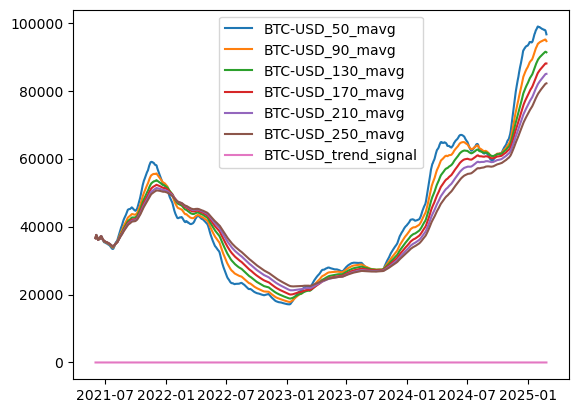

In [30]:
df_trend[mavg_col_list].plot()

<Axes: >

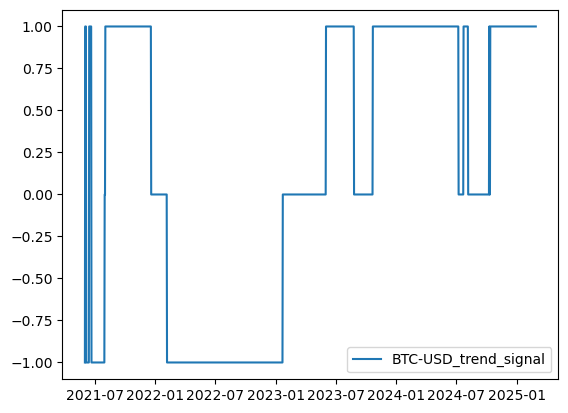

In [32]:
df_trend[[f'{ticker}_trend_signal']].plot()

In [34]:
def calculate_donchian_channels_timestamp(ticker_list):
    start_date = '2021-06-01'
    end_date = '2025-02-27'
    rolling_donchian_window = 20
    ticker_dict = {}
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()
    for ticker in ticker_list:
        df = load_coinbase_timestamp_price_pickle_file(ticker)
        open_price_col = f'{ticker}_8am_open_price'
        
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'] = (
            df[open_price_col].rolling(window=rolling_donchian_window).max())
    
        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'] = (
            df[open_price_col].rolling(window=rolling_donchian_window).min())
    
        # Middle of the channel (optional, could be just average of upper and lower)
        df[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price'] = (
                (df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'] +
                 df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']) / 2)
    
        # Shift only the Keltner channel metrics to avoid look-ahead bias
        df[[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']] = df[[
            f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price',
            f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']].shift(1)

        # Donchian Buy signal: Price crosses above upper band
        # Donchian Sell signal: Price crosses below lower band
        donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
        df[donchian_signal_col] = np.where(
            (df[open_price_col] > df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
            np.where((df[open_price_col] < df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']),
                     -1, 0))

        ticker_dict[ticker] = df

    df_final = pd.concat(ticker_dict, axis=1)
    df_final.columns = df_final.columns.droplevel(level=0)

    return df_final

In [36]:
df_donchian = calculate_donchian_channels_timestamp(ticker_list)

In [38]:
df_donchian.head()

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_8am_t_1_close,BTC-USD_20_donchian_upper_band_price,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_middle_band_price,BTC-USD_20_donchian_signal,ETH-USD_8am_open_price,ETH-USD_8am_close_price,ETH-USD_8am_t_1_close,ETH-USD_20_donchian_upper_band_price,ETH-USD_20_donchian_lower_band_price,ETH-USD_20_donchian_middle_band_price,ETH-USD_20_donchian_signal,LTC-USD_8am_open_price,LTC-USD_8am_close_price,LTC-USD_8am_t_1_close,LTC-USD_20_donchian_upper_band_price,LTC-USD_20_donchian_lower_band_price,LTC-USD_20_donchian_middle_band_price,LTC-USD_20_donchian_signal,SOL-USD_8am_open_price,SOL-USD_8am_close_price,SOL-USD_8am_t_1_close,SOL-USD_20_donchian_upper_band_price,SOL-USD_20_donchian_lower_band_price,SOL-USD_20_donchian_middle_band_price,SOL-USD_20_donchian_signal
2021-06-01,36601.20,36545.54,NaN,NaN,NaN,NaN,0,2624.78,2616.32,NaN,NaN,NaN,NaN,0,181.80,181.47,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-02,37204.26,37242.00,36545.54,NaN,NaN,NaN,0,2695.44,2699.21,2616.32,NaN,NaN,NaN,0,182.47,182.76,181.47,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-03,38791.36,38811.27,37242.00,NaN,NaN,NaN,0,2808.70,2810.43,2699.21,NaN,NaN,NaN,0,192.28,192.21,182.76,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-04,36587.77,36403.02,38811.27,NaN,NaN,NaN,0,2625.76,2607.40,2810.43,NaN,NaN,NaN,0,173.85,172.76,192.21,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-05,35915.26,35821.11,36403.02,NaN,NaN,NaN,0,2642.08,2633.10,2607.40,NaN,NaN,NaN,0,173.75,173.04,172.76,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
def get_trend_donchian_signal_for_portfolio_timestamp(ticker_list, fast_mavg=50, mavg_stepsize=6, slow_mavg=250, rolling_donchian_window=20, long_only=True):

    df_trend = create_trend_strategy_timestamp(ticker_list)
    df_donchian = calculate_donchian_channels_timestamp(ticker_list)

    donchian_cols = []
    for ticker in ticker_list:
        cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price',
                f'{ticker}_{rolling_donchian_window}_donchian_middle_band_price', f'{ticker}_{rolling_donchian_window}_donchian_signal']
        donchian_cols.extend(cols)
    df_final = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    for ticker in ticker_list:
        strategy_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        strategy_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        donchian_signal_col = f'{ticker}_{rolling_donchian_window}_donchian_signal'
        trend_signal_col = f'{ticker}_trend_signal'
        
        # Trend and Donchian Channel Signal
        buy_signal = ((df_final[donchian_signal_col] == 1) &
                      (df_final[trend_signal_col] == 1))
        sell_signal = ((df_final[donchian_signal_col] == -1) &
                       (df_final[trend_signal_col] == -1))
        
        # Generate Long Only Signal
        if long_only:
            df_final[strategy_signal_col] = np.where(buy_signal, 1, 0)
        # Generate Long & Short Signal
        else:
            df_final[strategy_signal_col] = np.where(buy_signal, 1, np.where(sell_signal, -1, 0))

        df_final[strategy_trades_col] = df_final[strategy_signal_col].diff()

    return df_final

In [92]:
df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list)

In [94]:
print(df_trend.shape)

(1368, 17)


In [96]:
df_trend.tail(200)

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_8am_t_1_close,BTC-USD_pct_returns,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg,BTC-USD_trend_signal,BTC-USD_20_donchian_upper_band_price,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_middle_band_price,BTC-USD_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades
2024-08-12,59874.43,59797.06,60698.49,-0.013576,62465.502631,62854.117426,62111.381264,60701.433380,59011.229019,57262.876566,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-13,58845.51,58849.89,59797.06,-0.015913,62323.542136,62766.016164,62061.520634,60679.726651,59009.658200,57275.488277,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-14,61340.31,61327.00,58849.89,0.042318,62284.984013,62734.681962,62050.509784,60687.452780,59031.750003,57307.880061,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-15,58744.40,58777.77,61327.00,-0.042112,62146.137581,62646.983458,62000.034825,60664.726993,59029.026268,57319.327405,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-16,58412.61,58421.66,58777.77,-0.006213,61999.724735,62553.920305,61945.264979,60638.386417,59023.183377,57328.039553,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-17,59135.31,59127.07,58421.66,0.012216,61887.394745,62478.786012,61902.364903,60620.806558,59024.246204,57342.441315,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-18,60020.79,59991.77,59127.07,0.015115,61814.194559,62424.764122,61873.638568,60613.788813,59033.692247,57363.784504,0,69574.98,51344.08,60459.530,0,0,0.0
2024-08-19,58404.81,58455.94,59991.77,-0.026453,61680.493204,62336.413482,61820.679352,60587.952778,59027.731196,57372.080209,0,66558.44,51344.08,58951.260,0,0,0.0
2024-08-20,60547.22,60541.69,58455.94,0.035775,61636.051117,62297.090548,61801.237225,60587.476371,59042.134129,57397.382187,0,66047.11,51344.08,58695.595,0,0,0.0
2024-08-21,59374.84,59391.77,60541.69,-0.019273,61547.376172,62232.865261,61764.192992,60573.293476,59045.287781,57413.140096,0,64640.62,51344.08,57992.350,0,0,0.0


In [48]:
def get_returns_volatility_timestamp(df, vol_range_list=[10], ticker='BTC-USD'):
    df[f'{ticker}_pct_returns'] = df[f'{ticker}_8am_open_price'].pct_change()
    for vol_range in vol_range_list:
        df[f'{ticker}_volatility_{vol_range}'] = df[f'{ticker}_pct_returns'].rolling(vol_range).std()

    return df

In [256]:
def get_volatility_adjusted_trend_signal_timestamp(df, ticker_list, volatility_window=20, fast_mavg=50, mavg_stepsize=6, slow_mavg=250,
                                                   rolling_donchian_window=20, annual_trading_days=365):
    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        trend_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        trend_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trend_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        donchian_upper_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'
        donchian_lower_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'

        ## Calculate Position Volatility Adjusted Trend Signal
        df = get_returns_volatility_timestamp(df, vol_range_list=[volatility_window], ticker=f'{ticker}')
        df[annualized_volatility_col] = (df[f'{ticker}_volatility_{volatility_window}'] * np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        df[f'{ticker}_t_1_8am_close'] = df[f'{ticker}_8am_close_price'].shift(1)
        trend_cols = [f'{ticker}_8am_open_price', f'{ticker}_8am_close_price', f'{ticker}_t_1_8am_close', f'{ticker}_pct_returns', trend_signal_col,
                      trend_trades_col, donchian_lower_band_col, donchian_upper_band_col, annualized_volatility_col, vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    ## Normalize the weights of each position by the total weight of the portfolio
    vol_normalized_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
    for ticker in ticker_list:
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = (df_signal[f'{ticker}_vol_adjusted_trend_signal'] /
                                                                      df_signal[vol_normalized_signal_cols].abs()
                                                                      .sum(axis=1))
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = df_signal[
            f'{ticker}_position_volatility_adjusted_weight'].fillna(0)

    return df_signal

In [264]:
df_signal = get_volatility_adjusted_trend_signal_timestamp(df_trend, ticker_list)

In [266]:
df_signal.shape

(1368, 11)

In [268]:
df_signal.head()

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_t_1_8am_close,BTC-USD_pct_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_upper_band_price,BTC-USD_annualized_volatility_20,BTC-USD_vol_adjusted_trend_signal,BTC-USD_position_volatility_adjusted_weight
2021-06-01,36601.20,36545.54,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0
2021-06-02,37204.26,37242.00,36545.54,0.016477,0,0.0,NaN,NaN,NaN,0.0,0.0
2021-06-03,38791.36,38811.27,37242.00,0.042659,0,0.0,NaN,NaN,NaN,0.0,0.0
2021-06-04,36587.77,36403.02,38811.27,-0.056806,0,0.0,NaN,NaN,NaN,0.0,0.0
2021-06-05,35915.26,35821.11,36403.02,-0.018381,0,0.0,NaN,NaN,NaN,0.0,0.0


In [60]:
# Function to calculate position sizes based on target volatility
def get_target_volatility_position_sizing_timestamp(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                    total_portfolio_value_upper_limit):
    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_position_volatility_adjusted_weight' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_8am_close' for ticker in ticker_list]
    open_price_cols = [f'{ticker}_8am_open_price' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and calculate the covariance matrix, portfolio volatility and scaling factors
    daily_weights = np.abs(df.loc[date, unscaled_weight_cols].values)
    daily_cov_matrix = cov_matrix.loc[date].values
    daily_portfolio_volatility = size.calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        scaling_factor = 0
    df.loc[date, 'target_vol_scaling_factor'] = scaling_factor

    # Scale the weights to target volatility
    scaled_weights = daily_weights * scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    # target_sizes = target_notionals / df.loc[date, t_1_price_cols].values
    target_sizes = target_notionals / df.loc[date, open_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    ## Check if the Target Notional is greater than the portfolio value
    if total_target_notional > total_portfolio_value_upper_limit:
        target_notional_scaling_factor = total_portfolio_value_upper_limit / total_target_notional
        df.loc[date, 'target_notional_scaling_factor'] = target_notional_scaling_factor
        adjusted_target_notionals = target_notionals * target_notional_scaling_factor
        df.loc[date, target_notional_cols] = adjusted_target_notionals

        # adjusted_target_sizes = adjusted_target_notionals / df.loc[date, t_1_price_cols].values
        adjusted_target_sizes = adjusted_target_notionals / df.loc[date, open_price_cols].values
        for i, ticker in enumerate(ticker_list):
            df.loc[date, f'{ticker}_target_size'] = adjusted_target_sizes[i]

        df.loc[date, 'total_target_notional'] = adjusted_target_notionals.sum()

    return df

In [182]:
def get_daily_positions_and_portfolio_cash_timestamp(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg, rolling_donchian_window,
                                                     transaction_cost_est, passive_trade_rate):

    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Estimated Transaction Costs and Fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    for ticker in ticker_list:
        t_1_close_price_col = f'{ticker}_t_1_8am_close'
        open_price_col = f'{ticker}_8am_open_price'
        close_price_col = f'{ticker}_8am_close_price'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        target_position_notional_col = f'{ticker}_target_notional'
        target_position_size_col = f'{ticker}_target_size'
        actual_position_notional_col = f'{ticker}_actual_position_notional'
        actual_position_size_col = f'{ticker}_actual_size'
        actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
        actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'

        ## ADD STOP LOSS IN DAILY POSITIONS
        short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
        upper_donchian_band_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price'
        lower_donchian_band_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price'
        stop_loss_col = f'{ticker}_stop_loss'
        event_col = f'{ticker}_event'
        df[actual_position_notional_col].loc[date] = 0.0
        df[actual_position_entry_price_col].loc[date] = 0.0
        df[actual_position_size_col].loc[date] = 0.0
        df[event_col].loc[date] = np.nan

        ## Taking a New Long position
        if (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == 0) and (
                df[actual_position_notional_col].loc[previous_date] == 0):
            # Building a cash buffer
            available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
            target_long_notional = df[target_position_notional_col].loc[date]
            if available_cash_buffer - target_long_notional > 0:
                net_long_notional = target_long_notional * (1 - est_fees)
                df[actual_position_notional_col].loc[date] = net_long_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
                df[event_col].loc[date] = 'New Long Position'

        ## Taking a New Short position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == 0) and (
                df[actual_position_notional_col].loc[previous_date] == 0):
            # Building a cash buffer
            available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
            target_short_notional = df[target_position_notional_col].loc[date]
            if available_cash_buffer - target_short_notional > 0:
                net_short_notional = -(target_short_notional * (1 - est_fees))
                df[actual_position_notional_col].loc[date] = net_short_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = -net_short_notional
                df[event_col].loc[date] = 'New Short Position'

        ## Open Long Position
        elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
            # df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
            #                                               df[t_1_close_price_col].loc[date])
            df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                          df[open_price_col].loc[date])
            df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
            df[event_col].loc[date] = 'Open Long Position'

        ## Open Short Position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == -1) and (
            df[actual_position_notional_col].loc[previous_date] < 0):
            df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
            # df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
            #                                               df[t_1_close_price_col].loc[date])
            df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                          df[open_price_col].loc[date])
            df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
            df[short_sale_proceeds_col].loc[date] = df[short_sale_proceeds_col].loc[previous_date]
            df[event_col].loc[date] = 'Open Short Position'

        ## Taking a New Long Position with an Open Short Position
        elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == -1) and (
                df[actual_position_notional_col].loc[previous_date] < 0):
            target_long_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
            if target_long_notional > 0:
                net_long_notional = target_long_notional * (1 - est_fees)
                df[actual_position_notional_col].loc[date] = net_long_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = 0.0
                df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
                df[event_col].loc[date] = 'New Long with Open Short Position'

        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            target_short_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
            if target_short_notional > 0:
                net_short_notional = -(target_short_notional * (1 - est_fees))
                df[actual_position_notional_col].loc[date] = net_short_notional
                # df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_entry_price_col].loc[date] = df[open_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = -net_short_notional
                df[event_col].loc[date] = 'New Short with Open Long Position'

        ## Closing a Long Position
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            # df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
            df[actual_position_exit_price_col].loc[date] = df[open_price_col].loc[date]
            closing_long_market_value = (df[actual_position_size_col].loc[previous_date] *
                                         df[actual_position_exit_price_col].loc[date])
            net_closing_long_market_value = closing_long_market_value * (1 - est_fees)
            df['available_cash'].loc[date] = (df['available_cash'].loc[date] + net_closing_long_market_value)
            df[event_col].loc[date] = 'Closing Long Position'

        ## Closing a Short Position
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == -1) and (
                df[actual_position_notional_col].loc[previous_date] < 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            # df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
            df[actual_position_exit_price_col].loc[date] = df[open_price_col].loc[date]
            df[short_sale_proceeds_col].loc[date] = 0.0
            closing_short_market_value = (df[actual_position_size_col].loc[previous_date] *
                                          df[actual_position_exit_price_col].loc[date])
            net_closing_short_market_value = closing_short_market_value * (1 - est_fees)
            short_sale_proceeds = df[short_sale_proceeds_col].loc[previous_date]
            df['available_cash'].loc[date] = (df['available_cash'].loc[date] +
                                              (net_closing_short_market_value + short_sale_proceeds))
            df[event_col].loc[date] = 'Closing Short Position'

        ## No Event
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            df[short_sale_proceeds_col].loc[date] = 0
            df[event_col].loc[date] = 'No Event'

    ## Calculate End of Day Portfolio Positions
    actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
    df['count_of_positions'].loc[date] = df[actual_position_notional_cols].loc[date].ne(0).sum()
    df['total_actual_position_notional'].loc[date] = df[actual_position_notional_cols].loc[date].sum()
    df['total_portfolio_value'].loc[date] = (df['available_cash'].loc[date] +
                                             df[short_sale_proceeds_cols].loc[date].sum() +
                                             df['total_actual_position_notional'].loc[date])

    return df

In [184]:
def get_target_volatility_daily_portfolio_positions_timestamp(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                              rolling_donchian_window, initial_capital, rolling_cov_window,
                                                              cash_buffer_percentage, annualized_target_volatility,
                                                              transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                              annual_trading_days=365, use_specific_start_date=False,
                                                              signal_start_date=None):

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    col_list = []
    for ticker in ticker_list:
        df[f'{ticker}_actual_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_actual_position_entry_price'] = 0.0
        df[f'{ticker}_actual_position_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['target_notional_scaling_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date:
        start_index_position = df.index.get_loc(signal_start_date)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[previous_date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing_timestamp(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                             total_portfolio_value_upper_limit)

        ## Get the daily positions
        df = get_daily_positions_and_portfolio_cash_timestamp(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg,
                                                              rolling_donchian_window, transaction_cost_est, passive_trade_rate)

        ## Calculate Portfolio Value and Available Cash
        # df = calculate_portfolio_cash_and_market_value_per_day(df, date, ticker_list, transaction_cost_est,
        #                                                        passive_trade_rate)

    return df

In [186]:
# Calculate Portfolio Returns and Rolling Sharpe Ratio
def calculate_portfolio_returns_timestamp(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                          rolling_sharpe_window):
    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    df['portfolio_daily_pct_returns'].replace([np.inf, -np.inf], 0, inplace=True)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    trade_cols = [
        f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    df['portfolio_strategy_cumulative_return'] = (1 + df['portfolio_daily_pct_returns']).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(
        df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
        strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False,
        annual_trading_days=365))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})

    return df

In [188]:
# Target Volatility Position Sizing Strategy for a Trend Following Signal
def apply_target_volatility_position_sizing_strategy_timestamp(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                               mavg_stepsize, rolling_donchian_window, long_only=False,
                                                               initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                               transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                               use_coinbase_data=True, rolling_sharpe_window=50,
                                                               cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                               annual_trading_days=365, use_specific_start_date=False,
                                                               signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                 slow_mavg=slow_mavg,
                                                                 mavg_stepsize=mavg_stepsize,
                                                                 rolling_donchian_window=rolling_donchian_window,
                                                                 long_only=long_only)

    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal_timestamp(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                               slow_mavg, rolling_donchian_window, annual_trading_days)
    
    ## Get Daily Positions
    df = get_target_volatility_daily_portfolio_positions_timestamp(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                                   rolling_donchian_window, initial_capital, rolling_cov_window,
                                                                   cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                                   use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = calculate_portfolio_returns_timestamp(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                               rolling_sharpe_window)

    return df

In [244]:
start_date = '2021-06-01'
end_date = '2025-02-27'
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
long_only=True
volatility_window = 20
annual_trading_days = 365
df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                             slow_mavg=slow_mavg,
                                                             mavg_stepsize=mavg_stepsize,
                                                             rolling_donchian_window=rolling_donchian_window,
                                                             long_only=long_only)

df_signal = get_volatility_adjusted_trend_signal_timestamp(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                           slow_mavg, rolling_donchian_window, annual_trading_days)

In [216]:
df_trend.head()

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_8am_t_1_close,BTC-USD_pct_returns,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg,BTC-USD_trend_signal,BTC-USD_20_donchian_upper_band_price,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_middle_band_price,BTC-USD_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_volatility_20,BTC-USD_annualized_volatility_20,BTC-USD_vol_adjusted_trend_signal,BTC-USD_t_1_8am_close
2021-06-01,36601.20,36545.54,NaN,NaN,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,-1,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0.0,NaN
2021-06-02,37204.26,37242.00,36545.54,0.016477,36908.760600,36906.080333,36905.049462,36904.503706,36904.165857,36903.936120,1,NaN,NaN,NaN,0,0,0.0,NaN,NaN,0.0,36545.54
2021-06-03,38791.36,38811.27,37242.00,0.042659,37561.559032,37548.523069,37543.517641,37540.869664,37539.231128,37538.117228,1,NaN,NaN,NaN,0,0,0.0,NaN,NaN,0.0,37242.00
2021-06-04,36587.77,36403.02,38811.27,-0.056806,37303.314152,37300.269887,37299.038744,37298.373504,37297.957035,37297.671807,1,NaN,NaN,NaN,0,0,0.0,NaN,NaN,0.0,38811.27
2021-06-05,35915.26,35821.11,36403.02,-0.018381,37003.059475,37010.821469,37013.702441,37015.203975,37016.125248,37016.748104,-1,NaN,NaN,NaN,0,0,0.0,NaN,NaN,0.0,36403.02


In [218]:
df_signal.head()

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_t_1_8am_close,BTC-USD_pct_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_upper_band_price,BTC-USD_annualized_volatility_20,BTC-USD_vol_adjusted_trend_signal,BTC-USD_position_volatility_adjusted_weight
2021-06-01,36601.20,36545.54,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0
2021-06-02,37204.26,37242.00,36545.54,0.016477,0,0.0,NaN,NaN,NaN,0.0,0.0
2021-06-03,38791.36,38811.27,37242.00,0.042659,0,0.0,NaN,NaN,NaN,0.0,0.0
2021-06-04,36587.77,36403.02,38811.27,-0.056806,0,0.0,NaN,NaN,NaN,0.0,0.0
2021-06-05,35915.26,35821.11,36403.02,-0.018381,0,0.0,NaN,NaN,NaN,0.0,0.0


In [190]:
start_date = '2021-06-01'
end_date = '2025-02-27'
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
long_only=True
df_final = apply_target_volatility_position_sizing_strategy_timestamp(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                               mavg_stepsize, rolling_donchian_window, long_only,
                                                               initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                               transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                               use_coinbase_data=True, rolling_sharpe_window=50,
                                                               cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                               annual_trading_days=365, use_specific_start_date=False,
                                                               signal_start_date=None)

In [192]:
df_final[df_final['BTC-USD_event'] != 'No Event'].head(200)

,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_8am_close_price,BTC-USD_8am_open_price,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_8am_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
2021-06-21,0,0.0,32715.10,32531.62,0.00,0.00,0.000000,0.000000,0.909328,NaN,-0.039699,0.0,0.0,33947.02,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,1.000000,1.0,0.000000,0.0,0.000000,NaN
2021-08-07,1,1.0,43806.97,43853.68,43853.68,0.00,2883.403471,0.065751,0.924501,New Long Position,0.082393,1.0,0.0,40573.92,2920.493741,0.066596,0.216333,1.081664,0.048391,12079.506259,1.0,2883.403471,2920.493741,14962.909729,13500.000000,0.216333,1.0,-0.002473,1.0,-0.002473,NaN
2021-08-08,1,0.0,44500.56,44486.15,43853.68,0.00,2924.988720,0.065751,0.911794,Open Long Position,0.014422,1.0,0.0,43806.97,2953.874154,0.066400,0.219348,1.096739,0.047725,12079.506259,1.0,2924.988720,2953.874154,15004.494978,13466.618757,0.219348,1.0,0.002779,0.0,0.000300,NaN
2021-08-09,1,0.0,45835.41,45981.76,43853.68,0.00,3023.325896,0.065751,0.858927,Open Long Position,0.033620,1.0,0.0,44500.56,3144.397705,0.068384,0.232849,1.164243,0.044958,12079.506259,1.0,3023.325896,3144.397705,15102.832155,13504.045480,0.232849,1.0,0.006554,0.0,0.006855,0.000000
2021-08-10,0,-1.0,45440.20,45369.31,0.00,45369.31,0.000000,0.000000,0.853183,Closing Long Position,-0.013319,0.0,0.0,45835.41,0.000000,0.000000,0.000000,0.000000,0.000000,15024.678408,0.0,0.000000,0.000000,15024.678408,13592.548939,0.000000,1.0,-0.005175,1.0,0.001645,0.000000
2021-08-13,1,1.0,46187.46,46170.99,46170.99,0.00,3086.371468,0.066847,0.865125,New Long Position,0.031345,1.0,0.0,44796.22,3126.072590,0.067706,0.231181,1.155903,0.045283,11898.605818,1.0,3086.371468,3126.072590,14984.977286,13522.210567,0.231181,1.0,-0.002642,1.0,-0.001002,0.000000
2021-08-14,1,0.0,46539.07,46603.67,46170.99,0.00,3115.294634,0.066847,0.865654,Open Long Position,0.009371,1.0,0.0,46187.46,3115.906573,0.066860,0.231039,1.155196,0.045310,11898.605818,1.0,3115.294634,3115.906573,15013.900452,13486.479558,0.231039,1.0,0.001930,0.0,0.000927,0.000000
2021-08-15,0,-1.0,45927.79,45957.51,0.00,45957.51,0.000000,0.000000,0.739528,Closing Long Position,-0.013865,0.0,0.0,46539.07,0.000000,0.000000,0.000000,0.000000,0.000000,14931.691201,0.0,0.000000,0.000000,14931.691201,13512.510407,0.000000,1.0,-0.005476,1.0,-0.004554,0.000000
2021-08-16,1,1.0,47536.65,47554.30,47554.30,0.00,3581.186111,0.075307,0.740975,New Long Position,0.034745,1.0,0.0,45927.79,3627.252214,0.076276,0.269915,1.349573,0.038784,11304.438987,1.0,3581.186111,3627.252214,14885.625098,13438.522081,0.269915,1.0,-0.003085,1.0,-0.007625,0.000000
2021-08-17,0,-1.0,46981.60,46869.92,0.00,46869.92,0.000000,0.000000,0.699238,Closing Long Position,-0.014392,0.0,0.0,47536.65,0.000000,0.000000,0.000000,0.000000,0.000000,14789.259765,0.0,0.000000,0.000000,14789.259765,13397.062588,0.000000,1.0,-0.006474,1.0,-0.014049,0.000000


<Axes: >

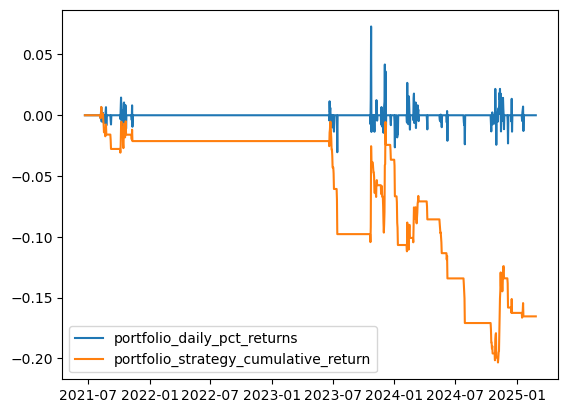

In [194]:
df_final[['portfolio_daily_pct_returns','portfolio_strategy_cumulative_return']].plot()

<Axes: >

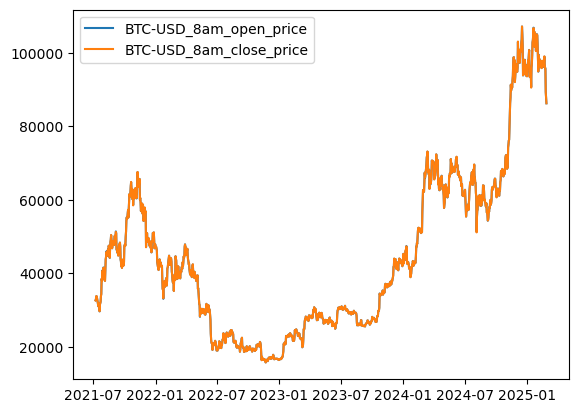

In [340]:
df_final[['BTC-USD_8am_open_price','BTC-USD_8am_close_price']].plot()

<Axes: xlabel='date'>

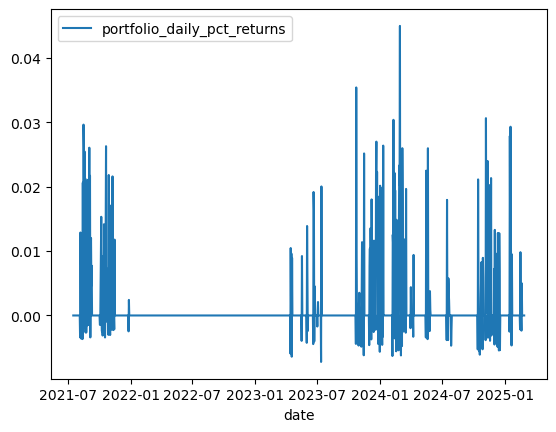

In [360]:
df_final_orig[['portfolio_daily_pct_returns']].plot()#,'portfolio_strategy_cumulative_return']].plot()

In [388]:
perf.calculate_risk_and_performance_metrics(df_final, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.048992655319855194,
 'annualized_sharpe_ratio': -1.19698184352084,
 'calmar_ratio': -0.0014849163245264612,
 'annualized_std_dev': 0.08008109151029559,
 'max_drawdown': -32.99354617539067,
 'max_drawdown_duration': Timedelta('1298 days 00:00:00'),
 'hit_rate': 0.04673590504451038,
 't_statistic': -1.1293814178222432,
 'p_value': 0.2589380500192721,
 'trade_count': 94.0}

In [380]:
df_final[df_final['BTC-USD_event'] != 'No Event'].head(200)

,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_8am_close_price,BTC-USD_8am_open_price,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_8am_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
2021-06-21,0,0.0,32715.10,32531.62,0.00,0.00,0.000000,0.000000,0.909328,NaN,-0.039699,0.0,0.0,33947.02,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,1.000000,1.0,0.000000,0.0,0.000000,NaN
2021-08-07,1,1.0,43806.97,43853.68,43806.97,0.00,2883.403471,0.065821,0.924501,New Long Position,0.082393,1.0,0.0,40573.92,2920.493741,0.066596,0.216333,1.081664,0.048391,12079.506259,1.0,2883.403471,2920.493741,14962.909729,13500.000000,0.216333,1.0,-0.002473,1.0,-0.002473,NaN
2021-08-08,1,0.0,44500.56,44486.15,43806.97,0.00,2929.056019,0.065821,0.911794,Open Long Position,0.014422,1.0,0.0,43806.97,2953.874154,0.066400,0.219348,1.096739,0.047725,12079.506259,1.0,2929.056019,2953.874154,15008.562278,13466.618757,0.219348,1.0,0.003051,0.0,0.000571,NaN
2021-08-09,1,0.0,45835.41,45981.76,43806.97,0.00,3016.916721,0.065821,0.858927,Open Long Position,0.033620,1.0,0.0,44500.56,3145.250064,0.068402,0.232849,1.164243,0.044958,12079.506259,1.0,3016.916721,3145.250064,15096.422979,13507.706050,0.232849,1.0,0.005854,0.0,0.006428,0.000000
2021-08-10,0,-1.0,45440.20,45369.31,0.00,45440.20,0.000000,0.000000,0.853183,Closing Long Position,-0.013319,0.0,0.0,45835.41,0.000000,0.000000,0.000000,0.000000,0.000000,15032.425521,0.0,0.000000,0.000000,15032.425521,13586.780682,0.000000,1.0,-0.004239,1.0,0.002162,0.000000
2021-08-13,1,1.0,46187.46,46170.99,46187.46,0.00,3087.962881,0.066857,0.865125,New Long Position,0.031345,1.0,0.0,44796.22,3127.684474,0.067741,0.231181,1.155903,0.045283,11904.741047,1.0,3087.962881,3127.684474,14992.703928,13529.182969,0.231181,1.0,-0.002642,1.0,-0.000486,0.000000
2021-08-14,1,0.0,46539.07,46603.67,46187.46,0.00,3111.470531,0.066857,0.865654,Open Long Position,0.009371,1.0,0.0,46187.46,3117.513215,0.066894,0.231039,1.155196,0.045310,11904.741047,1.0,3111.470531,3117.513215,15016.211578,13493.433535,0.231039,1.0,0.001568,0.0,0.001081,0.000000
2021-08-15,0,-1.0,45927.79,45957.51,0.00,45927.79,0.000000,0.000000,0.739528,Closing Long Position,-0.013865,0.0,0.0,46539.07,0.000000,0.000000,0.000000,0.000000,0.000000,14936.346480,0.0,0.000000,0.000000,14936.346480,13514.590420,0.000000,1.0,-0.005319,1.0,-0.004244,0.000000
2021-08-16,1,1.0,47536.65,47554.30,47536.65,0.00,3582.302623,0.075359,0.740975,New Long Position,0.034745,1.0,0.0,45927.79,3628.383089,0.076300,0.269915,1.349573,0.038784,11307.963391,1.0,3582.302623,3628.383089,14890.266015,13442.711832,0.269915,1.0,-0.003085,1.0,-0.007316,0.000000
2021-08-17,0,-1.0,46981.60,46869.92,0.00,46981.60,0.000000,0.000000,0.699238,Closing Long Position,-0.014392,0.0,0.0,47536.65,0.000000,0.000000,0.000000,0.000000,0.000000,14803.474110,0.0,0.000000,0.000000,14803.474110,13401.239413,0.000000,1.0,-0.005829,1.0,-0.013102,0.000000


In [385]:
df_final_orig[df_final_orig['BTC-USD_event'] != 'No Event'].head(200)

,BTC-USD,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-01,33516.11,0,-0.000000,0.0,0.00,0.00,0.000000,0.000000,1.002070,NaN,-0.044036,0.0,0.0,35060.00,0.000000,0.000000,0.000000,0.000000,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,1.000000,1.0,0.000000,0.0,0.000000,NaN
2021-08-06,42869.58,1,0.048445,1.0,40888.74,0.00,3977.591779,0.097278,0.670182,New Long Position,0.048445,1.0,0.0,40888.74,4028.756993,0.098530,0.298426,1.492132,0.035079,10971.243007,1.0,3977.591779,4028.756993,14948.834786,13500.000000,0.298426,1.0,-0.003411,1.0,-0.003411,NaN
2021-08-07,44637.34,1,0.041236,0.0,40888.74,0.00,4170.284753,0.097278,0.677531,Open Long Position,0.041236,1.0,0.0,42869.58,3971.464510,0.092641,0.295189,1.475947,0.035464,10971.243007,1.0,4170.284753,3971.464510,15141.527760,13453.951308,0.295189,1.0,0.012890,0.0,0.009435,NaN
2021-08-08,43829.14,0,-0.000000,-1.0,0.00,44637.34,0.000000,0.000000,0.663521,Closing Long Position,-0.018106,0.0,0.0,44637.34,0.000000,0.000000,0.000000,0.000000,0.000000,15258.346079,0.0,0.000000,0.000000,15258.346079,13627.374984,0.000000,1.0,0.007715,1.0,0.017223,NaN
2021-08-09,46285.48,1,0.056044,1.0,43829.14,0.00,4247.715555,0.096915,0.638372,New Long Position,0.056044,1.0,0.0,43829.14,4302.355470,0.098162,0.313297,1.566485,0.033414,10955.990609,1.0,4247.715555,4302.355470,15203.706164,13732.511471,0.313297,1.0,-0.003581,1.0,0.013580,NaN
2021-08-10,45595.66,0,-0.000000,-1.0,0.00,46285.48,0.000000,0.000000,0.605644,Closing Long Position,-0.014904,0.0,0.0,46285.48,0.000000,0.000000,0.000000,0.000000,0.000000,15384.793854,0.0,0.000000,0.000000,15384.793854,13683.335548,0.000000,1.0,0.011911,1.0,0.025653,NaN
2021-08-13,47833.64,1,0.076797,1.0,44422.14,0.00,4028.337838,0.090683,0.678715,New Long Position,0.076797,1.0,0.0,44422.14,4080.155817,0.091850,0.294675,1.473373,0.035526,11304.638036,1.0,4028.337838,4080.155817,15332.975875,13846.314468,0.294675,1.0,-0.003368,1.0,0.022198,NaN
2021-08-14,47109.65,0,-0.000000,-1.0,0.00,47833.64,0.000000,0.000000,0.688312,Closing Long Position,-0.015136,0.0,0.0,47833.64,0.000000,0.000000,0.000000,0.000000,0.000000,15587.252475,0.0,0.000000,0.000000,15587.252475,13799.678287,0.000000,1.0,0.016584,1.0,0.039150,NaN
2021-08-20,49342.40,1,0.055094,1.0,46765.87,0.00,4068.878032,0.087005,0.680795,New Long Position,0.055094,1.0,0.0,46765.87,4121.217494,0.088124,0.293774,1.468870,0.035634,11466.034982,1.0,4068.878032,4121.217494,15534.913013,14028.527228,0.293774,1.0,-0.003358,1.0,0.035661,0.000000


In [76]:
start_date_orig=pd.Timestamp(start_date).date()
end_date_orig=pd.Timestamp(end_date).date()
ticker_list = ['BTC-USD']
df_final_orig = size.apply_target_volatility_position_sizing_strategy(start_date_orig, end_date_orig, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only=True)

In [77]:
df_final_orig[df_final_orig['BTC-USD_position_volatility_adjusted_weight'] > 1].head(200)

,BTC-USD,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


<Axes: xlabel='date'>

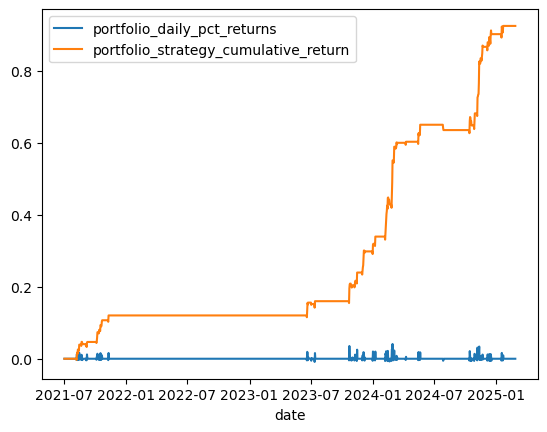

In [78]:
df_final_orig[['portfolio_daily_pct_returns','portfolio_strategy_cumulative_return']].plot()

In [98]:
df_trend = get_trend_donchian_signal_for_portfolio_timestamp(ticker_list)

In [104]:
df_trend_orig = tf.generate_trend_signal_with_donchian_channel(start_date=start_date_orig, end_date=end_date_orig, ticker=ticker, fast_mavg=fast_mavg,
                                                               slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='price',
                                                               rolling_donchian_window=20, long_only=True, use_coinbase_data=True)

In [108]:
df_trend.head()

,BTC-USD_8am_open_price,BTC-USD_8am_close_price,BTC-USD_8am_t_1_close,BTC-USD_pct_returns,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg,BTC-USD_trend_signal,BTC-USD_20_donchian_upper_band_price,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_middle_band_price,BTC-USD_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades
2021-06-01,36601.20,36545.54,NaN,NaN,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,36601.200000,-1,NaN,NaN,NaN,0,0,NaN
2021-06-02,37204.26,37242.00,36545.54,0.018025,36908.760600,36906.080333,36905.049462,36904.503706,36904.165857,36903.936120,1,NaN,NaN,NaN,0,0,0.0
2021-06-03,38791.36,38811.27,37242.00,0.041602,37561.559032,37548.523069,37543.517641,37540.869664,37539.231128,37538.117228,1,NaN,NaN,NaN,0,0,0.0
2021-06-04,36587.77,36403.02,38811.27,-0.057290,37303.314152,37300.269887,37299.038744,37298.373504,37297.957035,37297.671807,1,NaN,NaN,NaN,0,0,0.0
2021-06-05,35915.26,35821.11,36403.02,-0.013399,37003.059475,37010.821469,37013.702441,37015.203975,37016.125248,37016.748104,-1,NaN,NaN,NaN,0,0,0.0


In [105]:
df_trend_orig.head()

,BTC-USD,BTC-USD_pct_returns,BTC-USD_50_mavg,BTC-USD_50_mavg_slope,BTC-USD_90_mavg,BTC-USD_90_mavg_slope,BTC-USD_130_mavg,BTC-USD_130_mavg_slope,BTC-USD_170_mavg,BTC-USD_170_mavg_slope,BTC-USD_210_mavg,BTC-USD_210_mavg_slope,BTC-USD_250_mavg,BTC-USD_250_mavg_slope,BTC-USD_ribbon_thickness,BTC-USD_trend_signal,BTC-USD_trend_strategy_returns_50_6_250,BTC-USD_trend_strategy_trades_50_6_250,BTC-USD_trend_slope_signal,BTC-USD_trend_slope_strategy_returns,BTC-USD_trend_slope_strategy_trades,BTC-USD_20_donchian_upper_band_price,BTC-USD_20_donchian_lower_band_price,BTC-USD_20_donchian_middle_band_price,BTC-USD_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-11,37338.44,0.017561,36327.385168,-35.761483,36346.917336,-33.808266,36355.090711,-32.990929,36359.561521,-32.543848,36362.378192,-32.262181,36364.314724,-32.068528,-60.323016,-1.0,-0.017561,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,0,0,0.0,NaN
2021-06-12,35557.33,-0.047702,36248.177956,-89.220614,36272.782157,-86.363345,36282.842383,-85.204689,36288.298848,-84.578236,36291.721244,-84.185973,36294.067765,-83.917305,-36.929556,-1.0,0.047702,0.0,-1.0,0.047702,-1.0,NaN,NaN,NaN,0,0,-0.0,0.0
2021-06-13,39015.24,0.097249,36515.765387,-135.563318,36512.999623,-134.316352,36512.971054,-133.733866,36513.187816,-133.402452,36513.402167,-133.189328,36513.582853,-133.040934,-45.889809,-1.0,-0.097249,0.0,-1.0,-0.097249,0.0,NaN,NaN,NaN,0,0,0.0,0.0
2021-06-14,40539.47,0.039068,36883.722421,-71.853449,36843.970063,-75.389092,36830.216188,-76.588352,36823.285853,-77.186566,36819.118145,-77.544094,36816.337755,-77.781611,2.182534,0.0,0.000000,1.0,-1.0,-0.039068,0.0,NaN,NaN,NaN,0,0,0.0,0.0
2021-06-15,40162.37,-0.009302,37168.663063,1.261022,37101.244819,-6.644435,37077.073434,-9.495168,37064.687958,-10.960098,37057.165532,-11.851380,37052.114025,-12.450595,67.384667,1.0,-0.009302,1.0,1.0,-0.009302,2.0,NaN,NaN,NaN,0,0,-0.0,0.0


In [136]:
df_trend[mavg_cols].tail(10)

,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg
2025-02-18,97981.847278,94829.606202,90961.461037,87387.586514,84189.813444,81303.691857
2025-02-19,97909.605424,94858.399033,91040.517815,87489.950192,84303.082590,81421.909128
2025-02-20,97891.087564,94915.080373,91138.180139,87606.294647,84427.578782,81549.524985
2025-02-21,97931.878640,95003.348057,91257.158457,87738.750397,84565.054753,81688.027432
2025-02-22,97887.846929,95043.034253,91341.920466,87844.836018,84681.112037,81808.516042
2025-02-23,97803.939990,95058.532841,91409.192214,87937.273268,84786.013773,81919.591406
2025-02-24,97725.471363,95074.894537,91476.273097,88029.269964,84890.440324,82030.218098
2025-02-25,97397.982682,94949.611360,91444.185110,88045.003767,84932.943450,82088.739402
2025-02-26,97023.679832,94793.647594,91389.361826,88042.761150,84960.624237,82134.672655
2025-02-27,96600.903368,94605.718636,91310.789585,88021.709906,84972.778346,82167.407953


In [150]:
date_cond = (df_trend_orig.index >= pd.Timestamp('2023-01-01').date()) & (df_trend_orig.index <= pd.Timestamp('2023-12-31').date())
df_trend_orig[date_cond][mavg_cols].tail(10)

,BTC-USD_50_mavg,BTC-USD_90_mavg,BTC-USD_130_mavg,BTC-USD_170_mavg,BTC-USD_210_mavg,BTC-USD_250_mavg
date,,,,,,
2023-12-22,39312.483353,36472.917647,34618.846751,33294.658348,32293.840500,31532.541245
2023-12-23,39485.576163,36632.333742,34757.892680,33416.668451,32402.220090,31629.757483
2023-12-24,39624.378274,36772.832561,34884.108586,33529.048782,32502.923642,31720.606914
2023-12-25,39779.879910,36922.653165,35017.017992,33646.718763,32608.025149,31815.233248
2023-12-26,39887.160306,37045.573535,35131.499152,33750.449202,32701.947420,31900.541194
2023-12-27,40027.836372,37186.866424,35258.871751,33864.181412,32804.069192,31992.813198
2023-12-28,40127.969456,37305.423865,35370.663538,33966.136783,32896.755583,32077.228451
2023-12-29,40203.870654,37409.995869,35472.843536,34060.843657,32983.654716,32156.842412
2023-12-30,40279.837687,37513.974641,35574.647960,34155.350197,33070.465401,32236.439819


In [172]:
df_final.head()

,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_8am_close_price,BTC-USD_8am_open_price,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_8am_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
2021-06-21,0,0.0,32715.10,32531.62,0.0,0.0,0.0,0.0,0.909328,NaN,-0.039699,0.0,0.0,33947.02,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN
2021-06-22,0,0.0,31160.34,31213.87,0.0,0.0,0.0,0.0,0.916266,No Event,-0.040507,0.0,0.0,32715.10,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.0,0.0,0.0,0.0,NaN
2021-06-23,0,0.0,33877.01,33936.06,0.0,0.0,0.0,0.0,0.980760,No Event,0.087211,0.0,0.0,31160.34,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.0,0.0,0.0,0.0,NaN
2021-06-24,0,0.0,33925.97,33853.52,0.0,0.0,0.0,0.0,0.953157,No Event,-0.002432,0.0,0.0,33877.01,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.0,0.0,0.0,0.0,NaN
2021-06-25,0,0.0,33355.37,33324.34,0.0,0.0,0.0,0.0,0.952361,No Event,-0.015631,0.0,0.0,33925.97,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,0.0,15000.0,13500.0,0.0,1.0,0.0,0.0,0.0,NaN


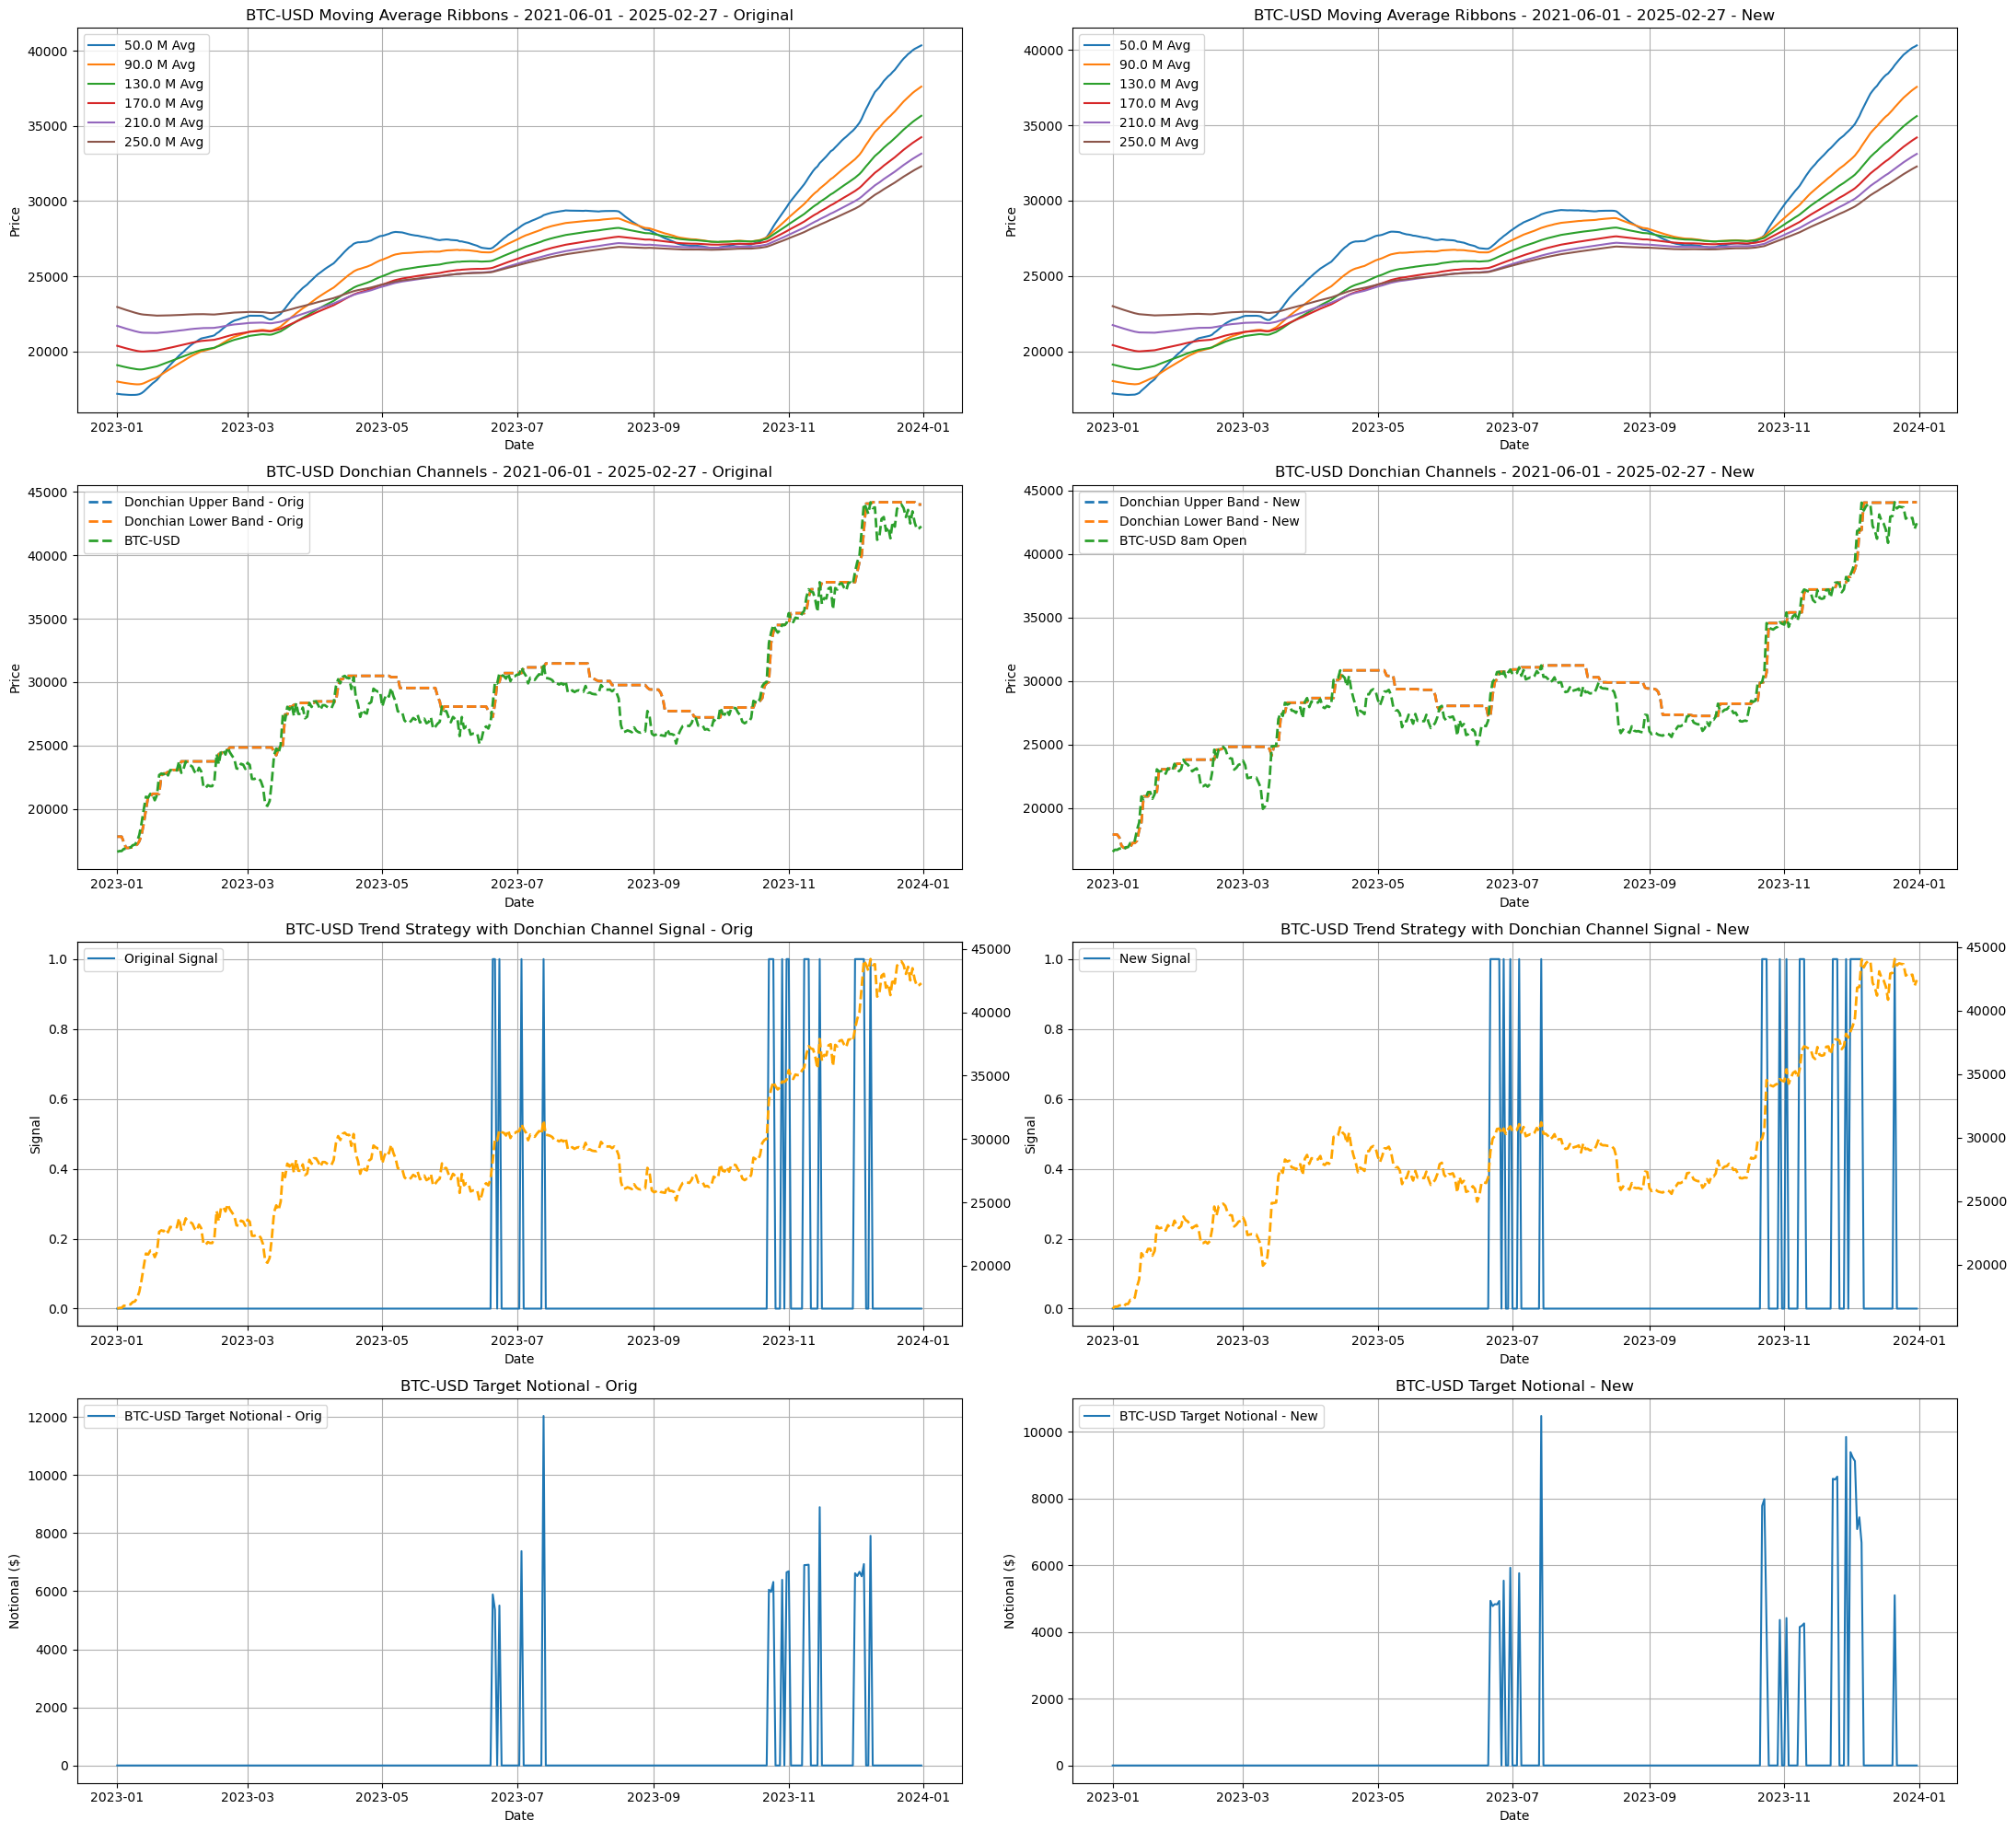

In [180]:
start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
ticker = 'BTC-USD'
price_or_returns_calc = 'price'
fig = plt.figure(figsize=(22,20))
layout = (4,2)
mavg_ax_orig = plt.subplot2grid(layout, (0,0))
mavg_ax_new = plt.subplot2grid(layout, (0,1))
donchian_ax_orig = plt.subplot2grid(layout, (1,0))
donchian_ax_new = plt.subplot2grid(layout, (1,1))
trend_signal_ax_orig = plt.subplot2grid(layout, (2,0))
trend_signal_ax_orig_2 = trend_signal_ax_orig.twinx()
trend_signal_ax_new = plt.subplot2grid(layout, (2,1))
trend_signal_ax_new_2 = trend_signal_ax_new.twinx()
target_notional_ax_orig = plt.subplot2grid(layout, (3,0))
target_notional_ax_new = plt.subplot2grid(layout, (3,1))


mavg_cols = ['BTC-USD_50_mavg', 'BTC-USD_90_mavg', 'BTC-USD_130_mavg', 'BTC-USD_170_mavg',
             'BTC-USD_210_mavg', 'BTC-USD_250_mavg']
orig_date_cond = (df_trend_orig.index >= pd.Timestamp('2023-01-01').date()) & (df_trend_orig.index <= pd.Timestamp('2023-12-31').date())
new_date_cond = (df_trend.index >= pd.Timestamp('2023-01-01').date()) & (df_trend.index <= pd.Timestamp('2023-12-31').date())
for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
    _ = mavg_ax_orig.plot(df_trend_orig[orig_date_cond].index, df_trend_orig[orig_date_cond][f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')
    _ = mavg_ax_new.plot(df_trend[new_date_cond].index, df_trend[new_date_cond][f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

_ = donchian_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                  df_trend_orig[orig_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band - Orig', linestyle='--', linewidth=2)
_ = donchian_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                  df_trend_orig[orig_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Lower Band - Orig', linestyle='--', linewidth=2)
_ = donchian_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                  df_trend_orig[orig_date_cond][f'{ticker}'], label=f'{ticker}', linestyle='--', linewidth=2)
_ = donchian_ax_new.plot(df_trend[new_date_cond].index,
                  df_trend[new_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band - New', linestyle='--', linewidth=2)
_ = donchian_ax_new.plot(df_trend[new_date_cond].index,
                  df_trend[new_date_cond][f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Lower Band - New', linestyle='--', linewidth=2)
_ = donchian_ax_new.plot(df_trend[new_date_cond].index,
                  df_trend[new_date_cond][f'{ticker}_8am_open_price'], label=f'{ticker} 8am Open', linestyle='--', linewidth=2)

_ = trend_signal_ax_orig.plot(df_trend_orig[orig_date_cond].index,
                              df_trend_orig[orig_date_cond][f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label=f'Original Signal')
_ = trend_signal_ax_orig_2.plot(df_trend_orig[orig_date_cond].index,
                              df_trend_orig[orig_date_cond][f'{ticker}'], label=f'{ticker}', linestyle='--', linewidth=2, color='orange')
_ = trend_signal_ax_new.plot(df_trend[new_date_cond].index,
                             df_trend[new_date_cond][f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label=f'New Signal')
_ = trend_signal_ax_new_2.plot(df_trend[new_date_cond].index,
                             df_trend[new_date_cond][f'{ticker}_8am_open_price'], label=f'{ticker} 8am Open', linestyle='--', linewidth=2, color='orange')

orig_date_cond = (df_final_orig.index >= pd.Timestamp('2023-01-01').date()) & (df_final_orig.index <= pd.Timestamp('2023-12-31').date())
new_date_cond = (df_final.index >= pd.Timestamp('2023-01-01').date()) & (df_final.index <= pd.Timestamp('2023-12-31').date())
_ = target_notional_ax_orig.plot(df_final_orig[orig_date_cond].index, df_final_orig[orig_date_cond][f'{ticker}_target_notional'], label=f'{ticker} Target Notional - Orig')
_ = target_notional_ax_new.plot(df_final[new_date_cond].index, df_final[new_date_cond][f'{ticker}_target_notional'], label=f'{ticker} Target Notional - New')

_ = mavg_ax_orig.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date} - Original')
_ = mavg_ax_orig.set_ylabel('Price')
_ = mavg_ax_orig.set_xlabel('Date')
_ = mavg_ax_orig.legend(loc='upper left')
_ = mavg_ax_orig.grid()

_ = mavg_ax_new.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date} - New')
_ = mavg_ax_new.set_ylabel('Price')
_ = mavg_ax_new.set_xlabel('Date')
_ = mavg_ax_new.legend(loc='upper left')
_ = mavg_ax_new.grid()

_ = donchian_ax_orig.set_title(f'{ticker} Donchian Channels - {start_date} - {end_date} - Original')
_ = donchian_ax_orig.set_ylabel('Price')
_ = donchian_ax_orig.set_xlabel('Date')
_ = donchian_ax_orig.legend(loc='upper left')
_ = donchian_ax_orig.grid()

_ = donchian_ax_new.set_title(f'{ticker} Donchian Channels - {start_date} - {end_date} - New')
_ = donchian_ax_new.set_ylabel('Price')
_ = donchian_ax_new.set_xlabel('Date')
_ = donchian_ax_new.legend(loc='upper left')
_ = donchian_ax_new.grid()

_ = trend_signal_ax_orig.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal - Orig')
_ = trend_signal_ax_orig.set_ylabel('Signal')
_ = trend_signal_ax_orig.set_xlabel('Date')
_ = trend_signal_ax_orig.legend(loc='upper left')
_ = trend_signal_ax_orig.grid()

_ = trend_signal_ax_new.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal - New')
_ = trend_signal_ax_new.set_ylabel('Signal')
_ = trend_signal_ax_new.set_xlabel('Date')
_ = trend_signal_ax_new.legend(loc='upper left')
_ = trend_signal_ax_new.grid()

_ = target_notional_ax_orig.set_title(f'{ticker} Target Notional - Orig')
_ = target_notional_ax_orig.set_ylabel('Notional ($)')
_ = target_notional_ax_orig.set_xlabel('Date')
_ = target_notional_ax_orig.legend(loc='upper left')
_ = target_notional_ax_orig.grid()

_ = target_notional_ax_new.set_title(f'{ticker} Target Notional - New')
_ = target_notional_ax_new.set_ylabel('Notional ($)')
_ = target_notional_ax_new.set_xlabel('Date')
_ = target_notional_ax_new.legend(loc='upper left')
_ = target_notional_ax_new.grid()


# if price_or_returns_calc == 'price':
#     _ = trend_donchian_ax.plot(df.index, df[f'{ticker}'], label='Price')
# elif price_or_returns_calc == 'returns':
#     _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_pct_returns'], label='Returns')
# _ = trend_donchian_ax.plot(df.index,
#                   df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'], label='Donchian Upper Band', linestyle='--', linewidth=3)
# _ = trend_donchian_ax.plot(df.index,
#                   df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'], label='Donchian Lower Band', linestyle='--', linewidth=3)

# _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
# _ = trend_donchian_ax.set_ylabel('Price')
# _ = trend_donchian_ax.set_xlabel('Date')
# _ = trend_donchian_ax.legend(loc='upper left')
# _ = trend_donchian_ax.grid()

# _ = trend_signal_ax.plot(df.index,
#                          df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
# _ = trend_signal_ax2.plot(df.index, df[f'{ticker}'], label='Price', alpha=0.8, color='orange', linestyle='--')
# _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
# _ = trend_signal_ax.set_ylabel('Signal')
# _ = trend_signal_ax.set_xlabel('Date')
# _ = trend_signal_ax.legend(loc='upper left')
# _ = trend_signal_ax.grid()

# _ = trend_rolling_sharpe_ax.plot(df.index,
#                                  df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
#                                  label='Sharpe Ratio', color='orange')
# _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
# _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
# _ = trend_rolling_sharpe_ax.set_xlabel('Date')
# _ = trend_rolling_sharpe_ax.legend(loc='upper left')
# _ = trend_rolling_sharpe_ax.grid()

# _ = trend_return_ax.plot(df.index,
#                          df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
#                          label='Return')
# _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
# _ = trend_return_ax.set_ylabel('Return')
# _ = trend_return_ax.set_xlabel('Date')
# _ = trend_return_ax.legend(loc='upper left')
# _ = trend_return_ax.grid()

# # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
# _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
# _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
# _ = trend_cum_return_ax.set_ylabel('Cum. Return')
# _ = trend_cum_return_ax.set_xlabel('Date')
# _ = trend_cum_return_ax.legend(loc='upper left')
# _ = trend_cum_return_ax.grid()


plt.tight_layout()

In [64]:
start_quarter

datetime.date(2025, 1, 1)

In [152]:
start_date

'2025-01-01'

In [154]:
end_date

'2025-03-31'

In [158]:
ticker

'BTC-USD'

In [165]:
df_prices = get_coinbase_price_at_timestamp(client, ticker, start_date, end_date)

In [166]:
df_prices

,8am_open_price,8am_close_price
date,,
2025-01-01,93614.94,93583.67
2025-01-02,96754.55,96747.24
2025-01-03,96585.53,96591.16
2025-01-04,97853.76,97853.21
2025-01-05,97737.02,97737.01
2025-01-06,99131.85,99178.93
2025-01-07,100752.30,100727.87
2025-01-08,94852.71,94981.05
2025-01-09,93371.21,93354.87


In [ ]:
df

In [92]:
ticker_list = ['BTC-USD']#,'ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
start_date = '2021-07-01'
end_date = '2025-02-24'
# start_date = '2025-02-01'
# end_date = '2025-02-24'
start_quarter = pd.Timestamp(start_date).to_period("Q").start_time.date()
end_quarter = pd.Timestamp(end_date).to_period("Q").end_time.date()
ticker_dict = {}
current_start = start_quarter#.strftime('%Y-%m-%d')
while current_start < end_quarter:
    current_end = pd.Timestamp(current_start).to_period("Q").end_time.date().strftime('%Y-%m-%d')
    for ticker in ticker_list:
        print(ticker, f'{current_start} to {current_end}')
        df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)
        ticker_dict[ticker] = df
        
    current_start = (pd.Timestamp(current_start) + pd.DateOffset(months=3)).to_period("Q").start_time.date()

BTC-USD 2025-01-01 to 2025-03-31


In [94]:
ticker_dict

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [100]:
print(current_start, current_end)

2025-01-01 2025-03-31


In [125]:
current_start = start_quarter#.strftime('%Y-%m-%d')
ticker_dict_test = {}
for ticker in ticker_list:
    print(ticker, f'{current_start} to {current_end}')
    df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)
    ticker_dict_test[ticker] = df

BTC-USD 2025-01-01 to 2025-03-31


In [133]:
df_test = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)

In [129]:
current_end

'2025-03-31'

In [131]:
current_start

datetime.date(2025, 1, 1)

In [134]:
df_test

,8am_open_price,8am_close_price
date,,
2025-01-01,93614.94,93583.67
2025-01-02,96754.55,96747.24
2025-01-03,96585.53,96591.16
2025-01-04,97853.76,97853.21
2025-01-05,97737.02,97737.01
2025-01-06,99131.85,99178.93
2025-01-07,100752.30,100727.87
2025-01-08,94852.71,94981.05
2025-01-09,93371.21,93354.87


In [126]:
ticker_dict_test

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [111]:
current_start = start_quarter#.strftime('%Y-%m-%d')
ticker_dict = {}
# for ticker in ticker_list:
print(ticker, f'{current_start} to {current_end}')
df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=current_start.strftime('%Y-%m-%d'), end_date=current_end, save_to_file=False)
ticker_dict[ticker] = df

BTC-USD 2025-01-01 to 2025-03-31


In [112]:
ticker_dict

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [103]:
ticker_dict

{'BTC-USD':             8am_open_price  8am_close_price
 date                                       
 2025-01-01        93614.94         93583.67
 2025-01-02        96754.55         96747.24
 2025-01-03        96585.53         96591.16
 2025-01-04        97853.76         97853.21
 2025-01-05        97737.02         97737.01
 2025-01-06        99131.85         99178.93
 2025-01-07       100752.30        100727.87
 2025-01-08        94852.71         94981.05
 2025-01-09        93371.21         93354.87
 2025-01-10        95018.32         94997.79
 2025-01-11        94507.24         94544.88
 2025-01-12        94286.72         94298.56
 2025-01-13        90644.29         90509.77
 2025-01-14        95945.54         95999.32
 2025-01-15        96889.93         96891.48
 2025-01-16        99368.40         99284.16
 2025-01-17       102746.61        102879.91
 2025-01-18       103392.73        103405.45
 2025-01-19       104767.03        104823.45
 2025-01-20       106798.18        106696.79

In [45]:
pd.Timestamp(start_quarter).to_period("Q").end_time.date().strftime('%Y-%m-%d')

'2021-09-30'

In [43]:
end_quarter.strftime('%Y-%m-%d')

'2025-03-31'

In [37]:
pd.Timestamp(start_date).to_period("Q").start_time.date()

datetime.date(2021, 7, 1)

In [35]:
pd.Timestamp(start_date).to_period("Q").end_time.date()

datetime.date(2021, 9, 30)

In [148]:
start_date = '2025-01-01'
end_date = '2025-03-31'
ticker_dict = {}
for ticker in ticker_list:
    print(ticker)
    df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False)
    ticker_dict[ticker] = df

BTC-USD


KeyError: "None of ['date'] are in the columns"

In [ ]:
df_prices_test = pd.concat(ticker_dict, axis=1)

In [ ]:
df_prices_test#.drop_duplicates()

In [20]:
df_prices = pd.concat(ticker_dict, axis=1)

In [21]:
df_prices

BTC-USD                        ETH-USD                  \
           8am_open_price 8am_close_price 8am_open_price 8am_close_price   
date                                                                       
2025-02-01      102258.15       102220.83        3266.59         3263.12   
2025-02-02       98141.85        98173.98        3051.09         3054.13   
2025-02-03       94850.00        94906.90        2583.18         2584.80   
2025-02-04       99460.67        99355.47        2807.38         2804.04   
2025-02-05       98103.77        98058.32        2788.26         2787.38   
2025-02-06       98374.78        98323.30        2771.61         2769.77   
2025-02-07       97998.69        97996.56        2758.30         2756.40   
2025-02-08       96060.27        96086.28        2604.18         2605.15   
2025-02-09       96563.48        96518.18        2655.48         2655.61   
2025-02-10       97390.38        97460.09        2639.93         2642.13   
2025-02-11       97792.18        97762.09        2686.74         2686.99   
2025-02-12       95977.19        95939.58        2628.34         2629.32   
2025-02-13       95837.52        95791.25        2655.94         2652.46   
2025-02-14       96660.59        96709.52        2686.58         2688.72   
2025-02-15       97758.04        97804.32        2710.58         2711.63   
2025-02-16       97140.73        97137.59        2706.00         2706.70   
2025-02-17       96459.15        96430.88        2766.03         2764.70   
2025-02-18       96154.80        96240.00        2702.59         2701.73   
2025-02-19       96139.68        96196.57        2704.47         2709.53   
2025-02-20       97437.40        97478.55        2742.27         2742.62   
2025-02-21       98931.26        99000.00        2807.21         2809.85   

                  LTC-USD                        SOL-USD                  
           8am_open_price 8am_close_price 8am_open_price 8am_close_price  
date                                                                      
2025-02-01         123.62          123.74         229.11          228.84  
2025-02-02         114.11          114.48         208.21          208.79  
2025-02-03          96.06           96.20         195.29          195.50  
2025-02-04         103.02          102.83         211.31          210.74  
2025-02-05         105.17          105.28         204.94          204.78  
2025-02-06         105.59          105.61         198.31          198.22  
2025-02-07         105.33          105.31         198.64          198.50  
2025-02-08         102.29          102.13         193.82          194.00  
2025-02-09         107.06          107.11         201.70          201.64  
2025-02-10         116.97          117.16         202.87          203.12  
2025-02-11         129.16          128.93         202.39          202.37  
2025-02-12         115.90          116.00         196.44          196.63  
2025-02-13         120.92          120.70         191.17          190.89  
2025-02-14         128.05          128.19         197.06          197.10  
2025-02-15         131.99          131.92         195.69          195.75  
2025-02-16         132.25          132.19         192.67          192.61  
2025-02-17         124.31          124.22         186.00          185.76  
2025-02-18         127.59          127.69         170.65          170.63  
2025-02-19         135.92          136.21         171.62          172.08  
2025-02-20         128.53          128.46         173.41          173.40  
2025-02-21         134.86          135.14         178.23          178.46

In [81]:
df = save_historical_crypto_prices_at_timestamp_from_coinbase(ticker=ticker, user_start_date=True, start_date='2025-02-01', end_date='2025-02-24', save_to_file=False)

In [83]:
df

,8am_open_price,8am_close_price
date,,
2025-02-01,229.11,228.84
2025-02-02,208.21,208.79
2025-02-03,195.29,195.50
2025-02-04,211.31,210.74
2025-02-05,204.94,204.78
2025-02-06,198.31,198.22
2025-02-07,198.64,198.50
2025-02-08,193.82,194.00
2025-02-09,201.70,201.64


In [ ]:
df_prices_test = get_coinbase_price_at_timestamp(client, ticker, start_date='2025-02-15', end_date='2025-02-21')

In [ ]:
df_prices_test

In [ ]:
df_prices_test

In [ ]:
df_prices_test

In [ ]:
start_date='2025-02-20'
end_date='2025-02-21'
date_list = pd.date_range(start=start_date, end=end_date, freq="D")
# for date in date_list:
date = date_list[0]
print(date)
start_timestamp = int(datetime.datetime.strptime(f'{date.date()} 08:00:00','%Y-%m-%d %H:%M:%S').timestamp())
end_timestamp = int(datetime.datetime.strptime(f'{date.date()} 08:00:00','%Y-%m-%d %H:%M:%S').timestamp())
candle_list = client.get_candles(
                    product_id=ticker,
                    start=start_timestamp,
                    end=end_timestamp,
                    granularity='ONE_MINUTE'  # Hourly candles
                ).candles

price_data = []
# Extract 8 AM open price
candles = candle_list[-1]  # [timestamp, low, high, open, close, volume]
price_data.append({
    'date': datetime.datetime.utcfromtimestamp(int(candles['start'])).date(),
    '8am_open_price': float(candles['open']),
    '8am_close_price': float(candles['close'])
})

In [ ]:
candle_list

In [ ]:
price_data

In [ ]:
price_data

In [ ]:
start_timestamp

In [ ]:
end_timestamp

In [ ]:
int(datetime.datetime.strptime(f'{"2025-02-20"} 07:59:00','%Y-%m-%d %H:%M:%S').timestamp())

In [ ]:
int(datetime.datetime.strptime(f'{"2025-02-20"} 08:01:10','%Y-%m-%d %H:%M:%S').timestamp())

In [ ]:
datetime.datetime.utcfromtimestamp(1740056400)

In [ ]:
candle_list

In [ ]:
candle_list[-1]

In [ ]:
candle_list

In [ ]:
candles

In [ ]:
%%time
df_prices = get_coinbase_8am_price(client, ticker)

In [ ]:
df_prices.head()

In [ ]:
start_timestamp

In [ ]:
df_market_trades = client.get_market_trades(product_id=ticker, limit=1000, start=1740056340, end=1740056470)

In [ ]:
df_market_trades['trades']

In [ ]:
df_candles, candle_list = get_coinbase_daily_historical_price_data_hour(client, ticker, start_timestamp, end_timestamp)

In [ ]:
df_candles

In [ ]:
candle_list

In [ ]:
for candles in candle_list:
    print(datetime.datetime.utcfromtimestamp(int(candles['start'])), candles['low'])